## Kalman Filtering


In [1]:
import Simulator
import Observation
import Statistics
import LETKalmanFilter

### Definition of forward model

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators



In [2]:
timestamp = "2021_07_29-12_52_15"

grid, simulator = Simulator.from_file(timestamp)

### Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [3]:
import numpy as np

def prior(grid, phi):
    """
    Constructing a Matern-type covariance prior with Matern-parameter phi
    where the matrix is normalized with the standard deviation
    """
    # INPUT! Bell mean
    mean = 0.0*np.ones(grid.N_x)
    # INPUT! Constant var
    var  = 0.5*np.ones(grid.N_x)

    # Matern covariance
    dist_mat = np.copy(grid.dist_mat)
    cov = (1+phi*dist_mat)*np.exp(-phi*dist_mat)
    
    # Normalisation
    var_mesh = np.meshgrid(np.sqrt(var),np.sqrt(var))[0]*np.meshgrid(np.sqrt(var),np.sqrt(var))[1]    

    return mean, var_mesh, cov

Please remember to set priors!


c:\Users\florianb\Documents\advectionDiffusion\Ensemble.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  self.ensemble = np.random.multivariate_normal(mean, cov + nugget*np.eye(self.simulator.grid.N_x), self.N_e).transpose()


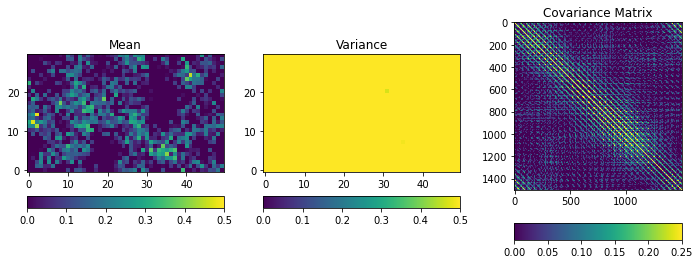

In [4]:
statistics = Statistics.Statistics(simulator, 50)
mean, var_mesh, cov = prior(grid=grid, phi=5.0)
statistics.set(mean, var_mesh*cov, nugget=0.5)
statistics.plot()

### Observations

In [5]:
observation = Observation.from_file(simulator)

Remember to set observation positions and to set values!


In [6]:
from matplotlib import pyplot as plt

In [7]:
scale_r = 5
observation_positions = observation.positions*np.array([grid.dx,grid.dy])
idx = 0
obs_loc = observation_positions[idx]

In [8]:
def getLocalIndices(obs_loc, scale_r, dx, dy, nx, ny):
    """ 
    Defines mapping from global domain (nx times ny) to local domain
    """

    boxed_r = dx*scale_r*1.5
    
    localIndices = np.array([[False]*nx]*ny)
    
    obs_loc_cellID = (int(obs_loc[0]//dx), int(obs_loc[1]//dy))

    #print(obs_loc_cellID)
    loc_cell_left  = int((obs_loc[0]-boxed_r   )//dx)
    loc_cell_right = int((obs_loc[0]+boxed_r+dx)//dx)
    loc_cell_down  = int((obs_loc[1]-boxed_r   )//dy)
    loc_cell_up    = int((obs_loc[1]+boxed_r+dy)//dy)

    xranges = []
    yranges = []
    
    xroll = 0
    yroll = 0

    if loc_cell_left < 0:
        xranges.append((nx+loc_cell_left , nx))
        xroll = loc_cell_left   # negative number
        loc_cell_left = 0 
    elif loc_cell_right > nx:
        xranges.append((0, loc_cell_right - nx))
        xroll = loc_cell_right - nx   # positive number
        loc_cell_right = nx 
    xranges.append((loc_cell_left, loc_cell_right))

    if loc_cell_down < 0:
        yranges.append((ny+loc_cell_down , ny))
        yroll = loc_cell_down   # negative number
        loc_cell_down = 0 
    elif loc_cell_up > ny:
        yranges.append((0, loc_cell_up - ny ))
        yroll = loc_cell_up - ny   # positive number
        loc_cell_up = ny
    yranges.append((loc_cell_down, loc_cell_up))

    for xrange in xranges:
        for yrange in yranges:
            localIndices[yrange[0] : yrange[1], xrange[0] : xrange[1]] = True

            for y in range(yrange[0],yrange[1]):
                for x in range(xrange[0], xrange[1]):
                    loc = np.array([(x+0.5)*dx, (y+0.5)*dy])

    return localIndices, xroll, yroll

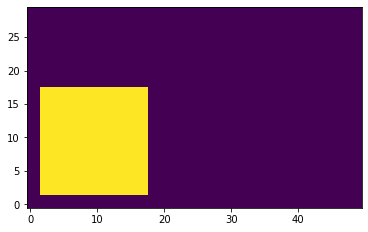

In [9]:
localIndices, xroll, yroll = getLocalIndices(np.array([1,1]), scale_r, grid.dx, grid.dy, grid.nx, grid.ny)
plt.imshow(localIndices, origin="lower")

In [10]:
def distGC(obs, loc, r, lx, ly):
    """
    Calculating the Gasparin-Cohn value for the distance between obs 
    and loc for the localisation radius r.
    
    obs: drifter positions ([x,y])
    loc: current physical location to check (either [x,y] or [[x1,y1],...,[xd,yd]])
    r: localisation scale in the Gasparin Cohn function
    lx: domain extension in x-direction (necessary for periodic boundary conditions)
    ly: domain extension in y-direction (necessary for periodic boundary conditions)
    """
    if not obs.shape == loc.shape: 
        obs = np.tile(obs, (loc.shape[0],1))
    
    if len(loc.shape) == 1:
        dist = min(np.linalg.norm(np.abs(obs-loc)),
                np.linalg.norm(np.abs(obs-loc) - np.array([lx,0 ])),
                np.linalg.norm(np.abs(obs-loc) - np.array([0 ,ly])),
                np.linalg.norm(np.abs(obs-loc) - np.array([lx,ly])) )
    else:
        dist = np.linalg.norm(obs-loc, axis=1)

    # scalar case
    if isinstance(dist, float):
        distGC = 0.0
        if dist/r < 1: 
            distGC = 1 - 5/3*(dist/r)**2 + 5/8*(dist/r)**3 + 1/2*(dist/r)**4 - 1/4*(dist/r)**5
        elif dist/r >= 1 and dist/r < 2:
            distGC = 4 - 5*(dist/r) + 5/3*(dist/r)**2 + 5/8*(dist/r)**3 -1/2*(dist/r)**4 + 1/12*(dist/r)**5 - 2/(3*(dist/r))
    # vector case
    else:
        distGC = np.zeros_like(dist)
        for i in range(len(dist)):
            if dist[i]/r < 1: 
                distGC[i] = 1 - 5/3*(dist[i]/r)**2 + 5/8*(dist[i]/r)**3 + 1/2*(dist[i]/r)**4 - 1/4*(dist[i]/r)**5
            elif dist[i]/r >= 1 and dist[i]/r < 2:
                distGC[i] = 4 - 5*(dist[i]/r) + 5/3*(dist[i]/r)**2 + 5/8*(dist[i]/r)**3 -1/2*(dist[i]/r)**4 + 1/12*(dist[i]/r)**5 - 2/(3*(dist[i]/r))

    return distGC

In [11]:
def getLocalWeightShape(scale_r, dx, dy, nx, ny):
    """
    Gives a local stencil with weights based on the distGC
    """
    
    local_nx = int(scale_r*2*1.5)+1
    local_ny = int(scale_r*2*1.5)+1
    weights = np.zeros((local_ny, local_ny))
    
    obs_loc_cellID = (local_ny, local_nx)
    obs_loc = np.array([local_nx*dx/2, local_ny*dy/2])

    for y in range(local_ny):
        for x in range(local_nx):
            loc = np.array([(x+0.5)*dx, (y+0.5)*dy])
            weights[y,x] = min(1, distGC(obs_loc, loc, scale_r*dx, nx*dx, ny*dy))
                        
    return weights

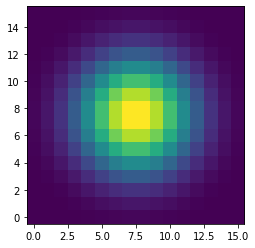

In [12]:
W_loc = getLocalWeightShape(scale_r , grid.dx, grid.dy, grid.nx, grid.ny)
plt.imshow(W_loc, origin="lower")

In [13]:
def getCombinedWeights(observation_positions, scale_r, dx, dy, nx, ny, W_loc):
    
    W_scale = np.zeros((ny, nx))
    
    num_drifters = observation_positions.shape[0]
    #print('found num_drifters:', num_drifters)
    if observation_positions.shape[1] != 2:
        print('observation_positions has wrong shape')
        return None

    # Get the shape of the local weights (drifter independent)
    W_loc = getLocalWeightShape(scale_r, dx, dy, nx, ny)
    
    for d in range(num_drifters):
        # Get local mapping for drifter 
        L, xroll, yroll = getLocalIndices(observation_positions[d,:], scale_r, dx, dy, nx, ny)

        # Roll weigths according to periodic boundaries
        W_loc_d = np.roll(np.roll(W_loc, shift=yroll, axis=0 ), shift=xroll, axis=1)
        
        # Add weights to global domain based on local mapping:
        W_scale[L] += W_loc_d.flatten()

        
    return W_scale

In [15]:
letkFilter = LETKalmanFilter.LETKalman(statistics, observation, 5)

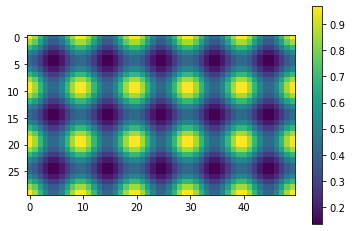

In [16]:
plt.imshow(letkFilter.W_forecast)
plt.colorbar()

In [17]:
X_f = np.zeros((statistics.ensemble.N_e, grid.ny, grid.nx))
for e in range(X_f.shape[0]):
    X_f[e] = np.reshape(statistics.ensemble.ensemble[:,e], (grid.ny, grid.nx))

In [18]:
X_f_mean = np.average(X_f, axis=0)
X_f_pert = X_f - X_f_mean

In [19]:
X_a = np.zeros_like(X_f)

In [20]:
N_x_local = letkFilter.W_loc.shape[0]*letkFilter.W_loc.shape[1] 

L = letkFilter.all_Ls[idx]
xroll = letkFilter.all_xrolls[idx]
yroll = letkFilter.all_yrolls[idx]

In [21]:
X_f_loc = np.zeros((statistics.ensemble.N_e, N_x_local))
X_f_loc[:,:] = X_f[:,L]          

In [22]:
X_f_loc_pert = np.zeros((statistics.ensemble.N_e, N_x_local))
X_f_loc_pert[:,:] = X_f_pert[:,L]

In [23]:
X_f_loc_mean = np.zeros((N_x_local))
X_f_loc_mean[:] = X_f_mean[L]

In [24]:
if not (xroll == 0 and yroll == 0):
    rolling_shape = (statistics.ensemble.N_e, letkFilter.W_loc.shape[0], letkFilter.W_loc.shape[1]) # roll around axis 2 and 3
    X_f_loc[:,:] = np.roll(np.roll(X_f_loc.reshape(rolling_shape), shift=-yroll, axis=1 ), shift=-xroll, axis=2).reshape((statistics.ensemble.N_e, N_x_local))
    X_f_loc_pert[:,:] = np.roll(np.roll(X_f_loc_pert.reshape(rolling_shape), shift=-yroll, axis=1 ), shift=-xroll, axis=2).reshape((statistics.ensemble.N_e, N_x_local))

    mean_rolling_shape = (letkFilter.W_loc.shape[0], letkFilter.W_loc.shape[1]) # roll around axis 1 and 2
    X_f_loc_mean[:] = np.roll(np.roll(X_f_loc_mean.reshape(mean_rolling_shape), shift=-yroll, axis=0 ), shift=-xroll, axis=1).reshape((N_x_local))

In [25]:
X_a_loc = X_f_loc.T

In [26]:
# Calculate weighted local analysis
weighted_X_a_loc = X_a_loc[:,:]*(np.tile(letkFilter.W_loc.flatten().T, (statistics.ensemble.N_e, 1)).T)
# Here, we use np.tile(W_loc.flatten().T, (N_e_active, 1)).T to repeat W_loc as column vector N_e_active times 

if not (xroll == 0 and yroll == 0):
    weighted_X_a_loc = np.roll(np.roll(weighted_X_a_loc[:,:].reshape((letkFilter.W_loc.shape[0], letkFilter.W_loc.shape[1], statistics.ensemble.N_e)), 
                                                                    shift=yroll, axis=0 ), 
                                    shift=xroll, axis=1)

X_a[:,L] += weighted_X_a_loc.reshape(letkFilter.W_loc.shape[0]*letkFilter.W_loc.shape[1], statistics.ensemble.N_e).T

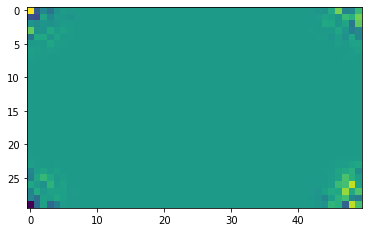

In [27]:
plt.imshow(X_a[0])